In [1]:
import random
import math
import csv
import os
import sys
import numpy as np
import pandas as pd
from pprint import pprint

import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from collections import deque
import matplotlib.pyplot as plt
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from IPython.display import clear_output, display

nPreamble = 54        # Number of preambles
nGrantUL = 12         # Number of UL Grant

maxRarWindow = 4
accessTime = 5

In [2]:
from datetime import datetime

# 현재 날짜와 시간을 가져옵니다.
now = datetime.now()

# 날짜와 시간을 'YYYYMMDDHHMMSS' 형식으로 출력합니다.
formatted_date_time = now.strftime('%Y%m%d%H%M')
print(formatted_date_time)

from tensorflow.keras.callbacks import TensorBoard

202401251905


In [3]:
if not os.path.exists(formatted_date_time):
    os.makedirs(formatted_date_time)

log_dir = formatted_date_time + "/ddpg/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)
summary_writer = tf.summary.create_file_writer(log_dir)

In [4]:
class MyResidualBlock(tf.keras.layers.Layer):
    def __init__(self, units=100):
        super(MyResidualBlock, self).__init__()
        self.units = units
        self.dense1 = tf.keras.layers.Dense(units, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units, activation='relu')
        self.dense_skip = tf.keras.layers.Dense(units)  # 차원을 맞춰주는 역할
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return x + self.dense_skip(inputs)  # 잔차 연결
    
    def get_config(self):
        config = super(MyResidualBlock, self).get_config()
        config.update({'units': self.units})
        return config

In [5]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [6]:
# 하이퍼 파라미터
BUFFER_SIZE = 10000
BATCH_SIZE = 32
GAMMA = 0.99
TAU = 0.001  # 타겟 네트워크의 soft update 비율
LR_ACTOR = 0.001
LR_CRITIC = 0.001

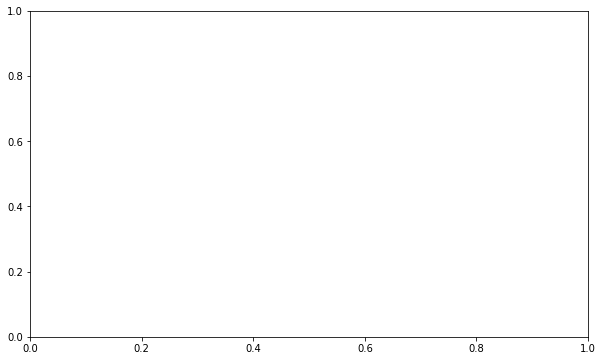

In [7]:
# Plot 초기 설정
plt.ion()
fig, ax = plt.subplots(figsize=(10, 6))
rewards = []

In [8]:
class Actor:
    def __init__(self, state_size):
        self.state_size = state_size
        self.model = self._build_model()
        
    def _build_model(self):
        states = tf.keras.layers.Input(shape=(self.state_size,))
        
        # 먼저 차원을 확장
        x = tf.keras.layers.Dense(100)(states)
        
        # Residual Blocks, 깊이를 5로 설정
        for _ in range(5):
            x = MyResidualBlock(100)(x)
        
        # backoff indicator는 0~1 사이의 값을 가질 수 있습니다.
        backoff_actions = tf.keras.layers.Dense(1, activation='sigmoid', name='backoff_actions')(x)
        retrans_actions = tf.keras.layers.Dense(1, activation='sigmoid', name='retrans_actions')(x)
        
        model = tf.keras.models.Model(inputs=states, outputs=[backoff_actions, retrans_actions])
        model.compile(loss=['mean_squared_error', 'mean_squared_error'], optimizer=tf.keras.optimizers.Adam(lr=LR_ACTOR))
        
        return model
    def predict(self, state):
        return self.model.predict(state)
    
    def predict_1(self, state):
        backoff_prob, retrans_prob = self.model.predict(state)
        
        # 0 ~ 1 범위의 값을 10 ~ 200 범위의 정수로 역정규화
        backoff_action = int(backoff_prob[0][0] * 190 + 10)
        retrans_action = int(retrans_prob[0][0] * 18 + 2)
        
        return backoff_action, retrans_action

In [9]:
# 크리틱 모델
class Critic:
    def __init__(self, state_size, backoff_action_size, retrans_action_size):
        self.state_size = state_size
        self.backoff_action_size = backoff_action_size
        self.retrans_action_size = retrans_action_size
        self.model = self._build_model()

    def _build_model(self):
        states = tf.keras.layers.Input(shape=(self.state_size,))
        backoff_actions = tf.keras.layers.Input(shape=(self.backoff_action_size,))
        retrans_actions = tf.keras.layers.Input(shape=(self.retrans_action_size,))
        
        x = tf.keras.layers.concatenate([states, backoff_actions, retrans_actions])
        
        # Residual Blocks, 깊이를 5로 설정
        for _ in range(5):
            x = MyResidualBlock(100)(x)
            
        Q_values = tf.keras.layers.Dense(1, activation='linear')(x)
        
        model = tf.keras.models.Model(inputs=[states, backoff_actions, retrans_actions], outputs=Q_values)
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=LR_CRITIC))
        
        return model

    def predict(self, state, backoff_action_probs, retrans_action_probs):
        return self.model.predict([state, backoff_action_probs, retrans_action_probs])

In [10]:
# 리플레이 버퍼
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.memory = deque(maxlen=self.buffer_size)

    def add(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [11]:
# OU Noise
class OUNoise:
    def __init__(self, action_size, mu=0, theta=0.15, sigma=0.2):
        self.action_size = action_size
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_size) * self.mu

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_size)
        self.state = x + dx
        return self.state

In [12]:
class UserInfo:
    def __init__(self, idx, timer, active, preamble, nTxPreamble, nTxPr,
                 rarWindow, msg1ReTx, msg2, msg2Receive, msg3Tx, msg3Wait, msg3Faile, msg4Process, txTime, nowBackoff, 
                 firstTxTime, secondTxTime, RaFailed, RA, idleTime, numberTx):
        self.idx = idx
        self.timer = timer
        self.active = active
        self.preamble = preamble
        self.nTxPreamble = nTxPreamble
        self.nTxPr = nTxPr
        self.rarWindow = rarWindow
        self.msg1ReTx = msg1ReTx
        self.msg2 = msg2
        self.msg2Receive = msg2Receive
        self.msg3Tx = msg3Tx
        self.msg3Wait = msg3Wait
        self.msg3Faile = msg3Faile
        self.msg4Process = msg4Process
        self.txTime = txTime
        self.nowBackoff = nowBackoff
        self.firstTxTime = firstTxTime
        self.secondTxTime = secondTxTime
        self.RaFailed = RaFailed
        self.RA = RA
        self.idleTime = idleTime
        self.numberTx = numberTx

In [13]:
def activeUE(user, time):
    user.active = 1
    user.preamble = random.randint(0, nPreamble-1)
    user.nTxPreamble = 1
    user.numberTx += 1
    
    user.txTime = time + 1
    tmp = random.randint(0, backoffIndicator-1)
    subTime = user.txTime + tmp

    if subTime % accessTime == 0:
        # 일정 시간 다음에 전송 시도
        user.txTime = subTime + 1
    elif subTime % accessTime == 1:
        # 일정 시간 다음에 전송 시도
        user.txTime = subTime
    else:
        # 일정 시간 다음에 전송 시도
        user.txTime = subTime + (accessTime - (subTime % accessTime) + 1)
        
    user.timer = 0
    user.rarWindow = 0
    user.msg1ReTx = 0
    user.nowBackoff = 0
    user.firstTxTime = time + 1

In [14]:
collision_allocation_probability = 0.676407778464641

def preambleCollisionDetection(user, activeCheck, time, grantCheck):
    user_tx = np.array([(user[i].idx, user[i].RA, user[i].txTime, user[i].msg2, user[i].nowBackoff, user[i].active, user[i].preamble) for i in range(activeCheck) if user[i].RA == 0 and user[i].txTime == time + 1 and user[i].msg2 == 0 and user[i].nowBackoff <= 0 and user[i].active == 1])

    if len(user_tx) > 0:
        preambleTxUEs = user_tx[:, 0].astype(int)
        preambles = np.zeros(nPreamble, dtype=int)
        userCheck = np.zeros((nPreamble, len(preambleTxUEs)), dtype=int)

        for i, ue_idx in enumerate(preambleTxUEs):
            RAPID = user_tx[i, 6]
            userCheck[RAPID, preambles[RAPID]] = ue_idx
            preambles[RAPID] += 1

        grantCheck = 0
        for i in range(nPreamble):
            if preambles[i] > 0 and grantCheck < nGrantUL:
                # Randomly decide whether to allocate resources to collided preambles
                for j in range(preambles[i]):
                    if preambles[i] == 1 or (preambles[i] > 1 and random.random() < collision_allocation_probability):
                        user[userCheck[i, j]].msg2 = 1
                        grantCheck += 1
                        if grantCheck >= nGrantUL:
                            break

    return grantCheck

In [15]:
def msg2Results(user, time):
    txLimit = 0
    if user.RA == 0:
        if user.msg2 == 0 and user.active == 1:
            user.rarWindow = 5
            user.txTime += 3
            user.numberTx += 1
            if user.rarWindow >= maxRarWindow:
#                 user.preamble = random.randint(0, nPreamble-1)
                user.nTxPr += 14
                user.nTxPreamble += 1
                user.rarWindow = 0
                user.msg1ReTx += 1
                
                oTx = 0
                oTx += user.nTxPr
                oTx += user.msg3Tx
                
                # 에너지 최소화를 위한 제약조건
                if user.idleTime != 0:
                    if user.idleTime > user.nTxPreamble*(oTx/user.idleTime)*(user.numberTx*0.5):
                        backoffRange = user.nTxPreamble * backoffIndicator
                        tmp = random.randint(0, backoffRange-1)
                    else:
                        tmp = random.randint(0, backoffIndicator-1)
                else:
                    tmp = random.randint(0, backoffIndicator-1)
                
                subTime = user.txTime + tmp

                if subTime % accessTime == 0:
                    # 일정 시간 다음에 전송 시도
                    user.txTime = subTime + 1
                elif subTime % accessTime == 1:
                    # 일정 시간 다음에 전송 시도
                    user.txTime = subTime
                else:
                    # 일정 시간 다음에 전송 시도
                    user.txTime = subTime + (accessTime - (subTime % accessTime) + 1)
                # backoff counter 설정
                user.nowBackoff = user.txTime - time - 1
                user.secondTxTime = user.txTime

                if user.msg1ReTx >= maxMsg1ReTx:
                    user.preamble = random.randint(0, nPreamble-1)
                    user.nTxPreamble = 1
                    user.RaFailed += 1
                    user.rarWindow = 0
                    user.msg1ReTx = 0
                    user.timer = 0
        elif user.msg2 == 1:
            user.numberTx += 1
            user.msg2Receive += 32.5
            user.active = 2
            # MSG 1에 대한 MSG 2수신 성공
            user.txTime += 10
            user.idleTime += 10
            user.secondTxTime = user.txTime
            user.msg3Wait = 0

In [16]:
def resourceRequestAllocation(user, activeCheck, time):
    for i in range(activeCheck):
        if user[i].txTime == time and user[i].msg2 == 1 and user[i].active == 2 and user[i].RA == 0:
            user[i].msg3Tx += 100
            if user[i].msg3Wait <= 48:
                p = random.random()
                user[i].idleTime += 49
                if p > 0.1:
                    user[i].active = 0
                    user[i].RA = 1
                    user[i].timer = user[i].timer + 6
                    user[i].msg4Process += 50
                else:
                    user[i].txTime += 49
                    user[i].msg3Wait = 49
            else:
                user[i].RA = 0
                user[i].RaFailed += 1
                user[i].msg3Faile += 1
                user[i].active = 1
                user[i].msg2 = 0
                user[i].preamble = random.randint(0, nPreamble-1)
                user[i].nTxPr += 14
                
                oTx = 0
                oTx += user[i].nTxPr
                oTx += user[i].msg3Tx

                # 에너지 최소화를 위한 제약조건
                if user[i].idleTime > user[i].nTxPreamble*(oTx/user[i].idleTime)*(user[i].numberTx*0.5):
                    backoffRange = user[i].nTxPreamble * backoffIndicator
                    tmp = random.randint(0, backoffRange-1)
                else:
                    tmp = random.randint(0, backoffIndicator-1)
                    
                subTime = user[i].txTime + tmp

                if subTime % accessTime == 0:
                    user[i].txTime = subTime + 1
                elif subTime % accessTime == 1:
                    user[i].txTime = subTime
                else:
                    user[i].txTime = subTime + (accessTime - (subTime % accessTime) + 1)
                user[i].secondTxTime = user[i].txTime
                user[i].nowBackoff = user[i].txTime - time - 1
                user[i].rarWindow = 0
                user[i].nTxPreamble = 1
                user[i].msg1ReTx = 0
                user[i].timer = 0
                user[i].numberTx += 1

In [17]:
def timerIncrease(user):
    user.timer += 1
    
    if user.nowBackoff > 0:
        user.nowBackoff -= 1
        user.idleTime += 1

In [18]:
def successUEs(user, nUE):
    success = 0
    for i in range(nUE):
        if user[i].RA == 1:
            success += 1
    return success

In [19]:
betaF = 0.0165

def betaDist(a, b, x):
    betaValue = (1 / betaF) * (pow(x, (a - 1))) * (pow((1 - x), (b - 1)))
    return betaValue

In [20]:
import time

start = time.time() # 시작
print(f"{time.time()-start:.4f} sec")

0.0010 sec


In [21]:
def normalize_and_average(data):
    # 데이터에서 최소값과 최대값을 가져옵니다.
    min_val = min(data)
    max_val = max(data)

    # 데이터를 정규화합니다.
    normalized_data = [(x - min_val) / (max_val - min_val) for x in data]

    # 정규화된 데이터의 평균을 반환합니다.
    return sum(normalized_data) / len(normalized_data)

In [22]:
def simulation(backoffIndicator):
    start = time.time() # 시작
#     random.seed(1)
    nTxPreambleList = []
    nPreReTx = []
    Logs = [['nUE', 'Success UEs', 'Average Delay', 'Average Energy', 'Average Failed', 'Average Idle Time', 'Average Tx']]
    Congestion = []
    ueTxPreambles = [0 for num in range(100)]
    ueReTx = 0
    UEs = [None] * nUE
    SlotIdle = []
    Congestion = []
    SlotEnergy = []
    SlotTime = []

    for i in range(nUE):
        UEs[i] = UserInfo(i, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

    activeCheck = 0
    grantCheck = 0

    maxTime = 10000
    nSuccessUE = 0
    totalEnergy = 0

    for intime in range(maxTime):
        nSuccessUE = 0

        if intime % accessTime == 0:
            grantCheck = 0

            numBetaDist = betaDist(3, 4, float(intime) / float(maxTime))
            accessUEs = int(math.ceil(float(nUE) * numBetaDist / (float(maxTime) / float(accessTime))))
            activeCheck += accessUEs

            if activeCheck >= nUE:
                activeCheck = nUE
            
            idleRAO = 0
            activationUE = 0
            slotEnergyConsumption = 0
            for i in range(activeCheck):
                if UEs[i].RA == 0 and UEs[i].active == 0:
                    activeUE(UEs[i], intime)

                if UEs[i].RA == 0 and UEs[i].active != 0:
                    activationUE += 1
                    idleRAO += UEs[i].idleTime
                    slotEnergyConsumption += UEs[i].nTxPr
                    slotEnergyConsumption += UEs[i].msg2Receive
                    slotEnergyConsumption += UEs[i].msg3Tx
                    slotEnergyConsumption += UEs[i].msg4Process

            if activationUE == 0:
                SlotIdle.append(0)
                Congestion.append(0)
                SlotEnergy.append(0)
            else:
                SlotIdle.append(idleRAO/activationUE)
                Congestion.append(activationUE/activeCheck)
                SlotEnergy.append(slotEnergyConsumption/activeCheck)

            preambleCollisionDetection(UEs, activeCheck, intime, grantCheck)

            for i in range(activeCheck):
                if UEs[i].nowBackoff <= 0 and UEs[i].txTime == intime + 1 and UEs[i].active == 1 and UEs[i].RA == 0:
                    msg2Results(UEs[i], intime + 1)

        resourceRequestAllocation(UEs, activeCheck, intime)

        for i in range(activeCheck):
            if UEs[i].active > 0 and UEs[i].RA == 0:
                timerIncrease(UEs[i])

        nSuccessUE = successUEs(UEs, nUE)
        if nSuccessUE == nUE:
            break

    totalSuccess = 0
    totalDelay = 0
    delayList = []
    for i in UEs:
        if i.RA == 1:
            totalSuccess += 1
            totalDelay += i.timer
            delayList.append(i.timer)
        totalEnergy += i.nTxPr
        totalEnergy += i.msg2Receive
        totalEnergy += i.msg3Tx
        totalEnergy += i.msg4Process
        totalEnergy += 100
            
    average_delay = normalize_and_average(delayList)
    
    totalCongestion = 0
    for i in range(len(Congestion)):
        totalCongestion += Congestion[i]
        
    mean_slotEnergy = np.mean(SlotEnergy)/1000
    
    return totalSuccess/nUE, totalCongestion/len(Congestion), average_delay, totalDelay/totalSuccess, totalEnergy/nUE * 0.001

In [23]:
import math

def log_scale(value, base=10):
    return math.log(value + 1, base)

def ReturnRewards(success_UEs, failed_UEs, energy, delay, backoff, maxTx, congestion):
    # 가중치 설정
    w_success = 0.3
    w_energy = 0.35
    w_delay = 0.35
    
    # 로그 스케일링
    success_log = log_scale(success_UEs)
    congestion_log = log_scale(congestion)
    energy_log = log_scale(energy)
    delay_log = log_scale(delay)
    
    # 보상 계산
    total_reward = (w_success * success_log - 
                    w_energy * energy_log - 
                    w_delay * delay_log)
    
    return total_reward

In [24]:
# 학습 코드
actor = Actor(state_size=5)  # Initialize Actor
critic = Critic(state_size=5, backoff_action_size=1, retrans_action_size=1)  # Initialize Critic
target_actor = Actor(state_size=5)  # Initialize target Actor
target_critic = Critic(state_size=5, backoff_action_size=1, retrans_action_size=1)  # Initialize target Critic
replay_buffer = ReplayBuffer(BUFFER_SIZE)
noise = OUNoise(action_size=3)  # backoff_action_size (3) + retrans_action_size (3) = 6
noise_1 = OUNoise(action_size = 1)
tensorboard_callback.set_model(critic.model) 

c:\users\jiha\appdata\local\programs\python\python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


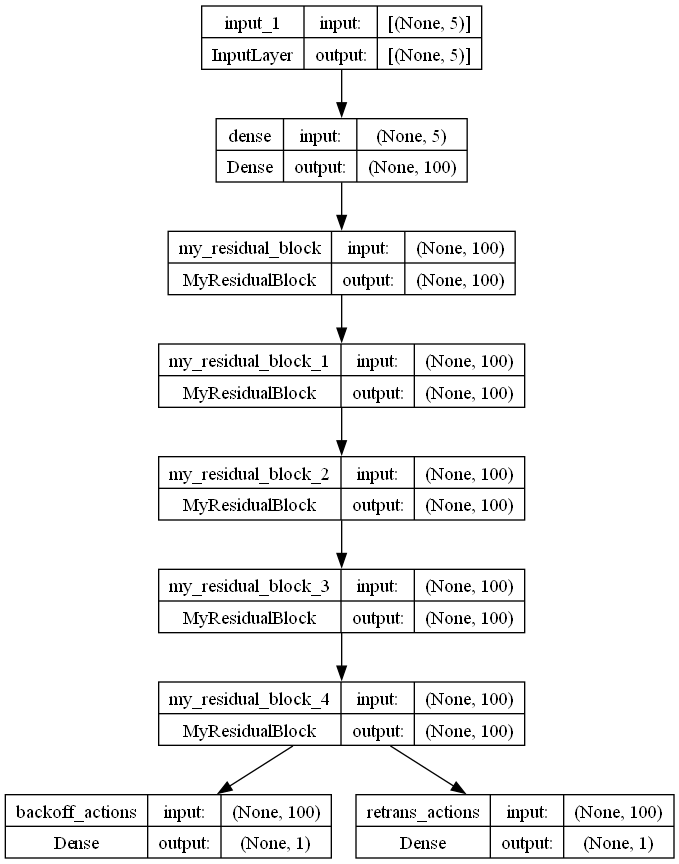

In [25]:
plot_model(actor.model, show_shapes=True, show_layer_names=True, to_file='Actor.png')

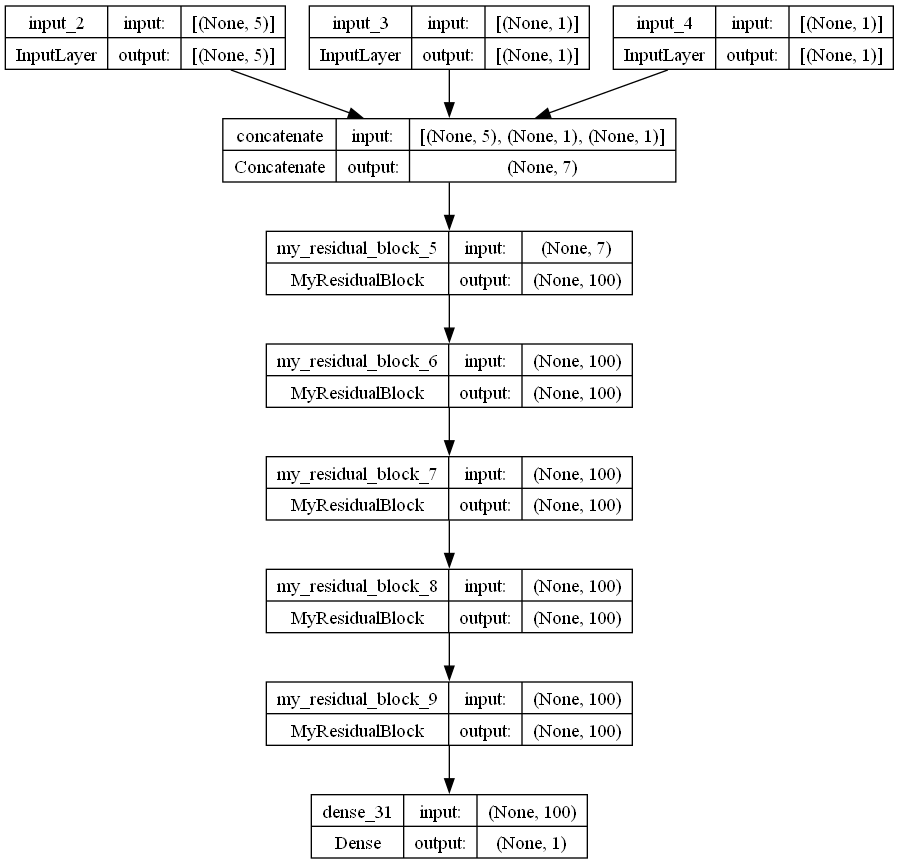

In [26]:
plot_model(critic.model, show_shapes=True, show_layer_names=True, to_file='Critic.png')

In [27]:
def add_noise(action_probs, scale=0.1, max_action=1, min_action=0):
    noise = np.random.randn(*action_probs.shape) * scale
    noisy_action_probs = action_probs + noise
    return np.clip(noisy_action_probs, min_action, max_action)

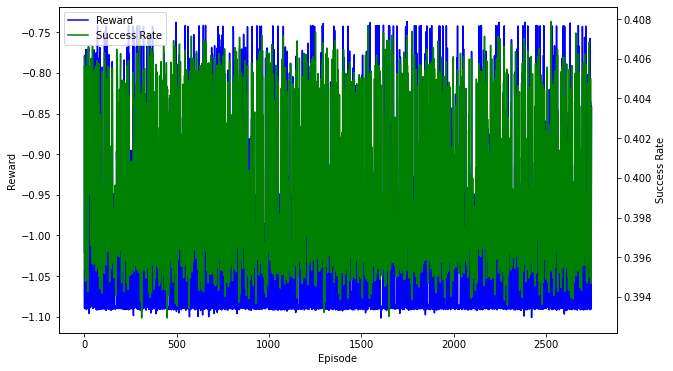

Episode: 2746, BackoffIndicator: 400, maxMsg1ReTx: 33, Reward: -0.8409, Congestion: 0.5999
- Success rate: 0.4035, Average access delay: 215.8256(0.2353)


In [ ]:
RewardList = []
rewards = []
success_ratio_list = []


backoffIndicator = 20
maxMsg1ReTx = 10
nUE = 50000

maximum_bi = 400
maximum_maxTx = 40

# 학습 시작 전 콜백 메서드 호출
tensorboard_callback.on_train_begin()

for episode in range(5000):
    if episode == 0:
        backoff_probs, retrans_probs = [[(backoffIndicator - 10) / (maximum_bi - 10)]], [[(maxMsg1ReTx - 2) / (maximum_maxTx - 2)]]

    else:
        with HiddenPrints():
            backoff_probs, retrans_probs = actor.predict(state)
            # Add noise for exploration
            backoff_probs = add_noise(backoff_probs, scale=1.0, max_action=1, min_action=0)
            retrans_probs = add_noise(retrans_probs, scale=1.0, max_action=1, min_action=0)

    backoff_action = int(backoff_probs[0][0] * (maximum_bi - 10) + 10)
    retrans_action = int(retrans_probs[0][0] * (maximum_maxTx - 2) + 2)
            
    success_ratio, congestion, n_average_delay, average_delay, meanUEEnergy = simulation(backoffIndicator)
    success_ratio_list.append(success_ratio)
    success_UEs = success_ratio * nUE
    failed_UEs = nUE - success_UEs
    
    # ["Reward", "Total Success", "Total Congestion", "N_Average Delay", "Total Average Delay", "Mean Slot Energy", "Backoff Indicator", "MaxTx"]
    reward = ReturnRewards(success_ratio, 1-success_ratio, meanUEEnergy, average_delay, backoffIndicator, maxMsg1ReTx, congestion)
#     reward = success_ratio
    rewards.append(reward)
    
    RewardList.append([reward, success_ratio, congestion, n_average_delay, average_delay, meanUEEnergy, backoffIndicator, maxMsg1ReTx])
            
    state = np.array([[backoff_probs[0][0], retrans_probs[0][0], success_ratio, average_delay, meanUEEnergy]])
    
    backoffIndicator = backoff_action
    maxMsg1ReTx = retrans_action
    
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Reward")
    ax1.plot(rewards, label='Reward', color='b')
    ax1.tick_params(axis='y')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel("Success Rate")
    ax2.plot(success_ratio_list, label='Success Rate', color='g')
    ax2.tick_params(axis='y')
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    plt.show()
    
    print(f"Episode: {episode}, BackoffIndicator: {backoffIndicator}, maxMsg1ReTx: {maxMsg1ReTx}, Reward: {reward:.4f}, Congestion: {congestion:.4f}")
    print(f"- Success rate: {success_ratio:.4f}, Average access delay: {average_delay:.4f}({n_average_delay:.4f})")
    
    new_state = np.array([[backoff_probs[0][0], retrans_probs[0][0], success_ratio, average_delay, meanUEEnergy]])
    replay_buffer.add(state, (backoff_probs, retrans_probs), reward, new_state)
    state = new_state
    
    with summary_writer.as_default():
        tf.summary.scalar('Reward', reward, step=episode)
        tf.summary.scalar('Success Ratio', success_ratio, step=episode)
        tf.summary.scalar('Congestion', congestion, step=episode)
        tf.summary.scalar('Average Delay', average_delay, step=episode)
        tf.summary.scalar('Mean UE Energy', meanUEEnergy, step=episode)
        tf.summary.scalar('Backoff Indicator', backoffIndicator, step=episode)
        tf.summary.scalar('MaxMsg1ReTx', maxMsg1ReTx, step=episode)
    
    if len(replay_buffer) >= BATCH_SIZE:
        experiences = replay_buffer.sample(BATCH_SIZE)
        for batch_num, (state, action, reward, next_state) in enumerate(experiences):
            
            with HiddenPrints():
                # 크리틱 업데이트
                target_backoff_probs, target_retrans_probs = target_actor.predict(next_state)
                target_Q = reward + GAMMA * target_critic.predict(next_state, target_backoff_probs, target_retrans_probs)
                
                action_0_reshaped = np.array([action[0]]).reshape(-1, 1)
                action_1_reshaped = np.array([action[1]]).reshape(-1, 1)

                critic_loss = critic.model.train_on_batch([state, action_0_reshaped, action_1_reshaped], target_Q)
                # 로스를 TensorBoard에 기록
                with summary_writer.as_default():
                    tf.summary.scalar('critic_loss', critic_loss, step=episode*BATCH_SIZE + batch_num)
                    
            # 액터 업데이트
            with tf.GradientTape() as tape:
                actions = actor.model(state)
                critic_value = critic.model([state, actions[0], actions[1]])
                actor_loss = -tf.math.reduce_mean(critic_value)
            actor_gradients = tape.gradient(actor_loss, actor.model.trainable_variables)
            actor.model.optimizer.apply_gradients(zip(actor_gradients, actor.model.trainable_variables))

            # 타겟 신경망 업데이트
            new_actor_weights = [TAU * a + (1 - TAU) * t for a, t in zip(actor.model.get_weights(), target_actor.model.get_weights())]
            target_actor.model.set_weights(new_actor_weights)
            
            new_critic_weights = [TAU * c + (1 - TAU) * t for c, t in zip(critic.model.get_weights(), target_critic.model.get_weights())]
            target_critic.model.set_weights(new_critic_weights)
            
    if episode % 10 == 0:
        with open('{}{}_ddpg_rewards_proposed.csv'.format(log_dir, nUE), 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Reward", "Total Success", "Total Congestion", "N_Average Delay", "Total Average Delay", "Mean Slot Energy", "Backoff Indicator", "MaxTx"])  # CSV 헤더
            writer.writerows(RewardList)  # 리스트의 내용을 한 번에 쓰기

# 학습 종료 후 콜백 메서드 호출
tensorboard_callback.on_train_end()

print("Training complete.")

In [ ]:
with open('{}{}_ddpg_rewards_proposed.csv'.format(log_dir, nUE), 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Reward", "Total Success", "Total Congestion", "N_Average Delay", "Total Average Delay", "Mean Slot Energy", "Backoff Indicator", "MaxTx"])  # CSV 헤더
    writer.writerows(RewardList)  # 리스트의 내용을 한 번에 쓰기

In [ ]:
from tensorflow.keras.models import load_model

actor_model_save_path = '{}{}_ddpg_actor_model'.format(log_dir, nUE)
actor.model.save(actor_model_save_path, save_format='tf')
loaded_actor_model = load_model(actor_model_save_path, custom_objects={'MyResidualBlock': MyResidualBlock})

critic_model_save_path = '{}{}_ddpg_critic_model'.format(log_dir, nUE)
critic.model.save(critic_model_save_path, save_format='tf')
loaded_critic_model = load_model(critic_model_save_path, custom_objects={'MyResidualBlock': MyResidualBlock})

target_actor_model_save_path = '{}{}_ddpg_target_actor_model'.format(log_dir, nUE)
target_actor.model.save(target_actor_model_save_path, save_format='tf')
loaded_target_actor_model = load_model(target_actor_model_save_path, custom_objects={'MyResidualBlock': MyResidualBlock})

target_critic_model_save_path = '{}{}_ddpg_target_critic_model'.format(log_dir, nUE)
target_critic.model.save(target_critic_model_save_path, save_format='tf')
loaded_target_critic_model = load_model(target_critic_model_save_path, custom_objects={'MyResidualBlock': MyResidualBlock})

In [ ]:
# 첫 번째 훈련 가능한(가중치를 가진) 레이어 찾기
for layer in actor.model.layers:
    if len(layer.get_weights()) > 0:
        first_trainable_layer = layer
        break

# 첫 번째 훈련 가능한 레이어의 가중치와 바이어스 가져오기
weights_1, biases_1 = first_trainable_layer.get_weights()

# 파라미터 출력
print("First trainable layer:", first_trainable_layer.name)
print("Weights:", weights_1)
print("Biases:", biases_1)

# 첫 번째 훈련 가능한(가중치를 가진) 레이어 찾기
for layer in loaded_actor_model.layers:
    if len(layer.get_weights()) > 0:
        first_trainable_layer = layer
        break

# 첫 번째 훈련 가능한 레이어의 가중치와 바이어스 가져오기
weights, biases = first_trainable_layer.get_weights()

# 파라미터 출력
print("First trainable layer:", first_trainable_layer.name)
print("Weights:", weights)
print("Biases:", biases)